#Movie Genre Classification with LSTM


Dataset : https://www.kaggle.com/lokkagle/movie-genre-data

###Import Library

In [ ]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Load Dataset

In [ ]:
moviedf = pd.read_csv("/content/drive/MyDrive/Subs1/kaggle_movie_train.csv")
moviedf.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


###Dataset Exploration and Preparation

In [ ]:
moviedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22579 entries, 0 to 22578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22579 non-null  int64 
 1   text    22579 non-null  object
 2   genre   22579 non-null  object
dtypes: int64(1), object(2)
memory usage: 529.3+ KB


In [ ]:
moviedf.isnull().sum()

id       0
text     0
genre    0
dtype: int64

In [ ]:
moviedf.describe()

,id
count,22579.000000
mean,14134.852651
std,8132.614667
min,0.000000
25%,7096.500000
50%,14168.000000
75%,21159.000000
max,28166.000000


In [ ]:
moviedf.genre.value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

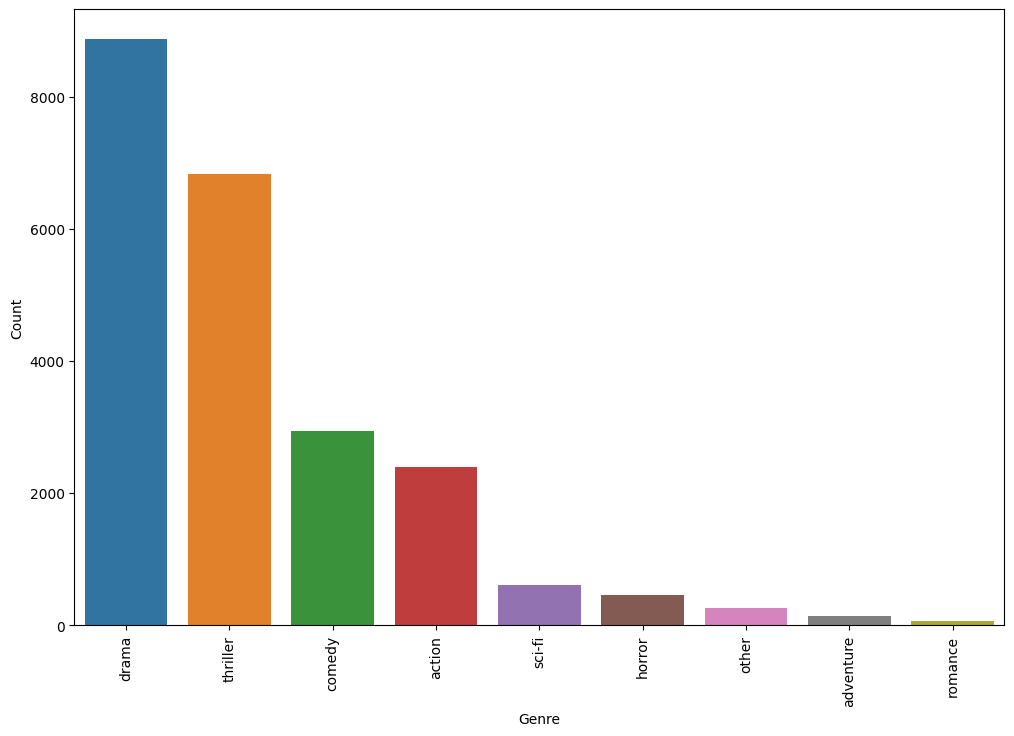

In [ ]:
plt.figure(figsize=(12,8))
counts = moviedf.genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);

####Filtering the genre into 5 genre

In [ ]:
others = moviedf[moviedf.groupby('genre')['genre'].transform('size') < 2000]
others = list(others.genre.unique())
def genre_filter(genre: str):
    return genre if genre not in others else 'other'

moviedf['genre'] = moviedf['genre'].apply(genre_filter)

In [ ]:
moviedf.genre.value_counts()

drama       8873
thriller    6824
comedy      2941
action      2392
other       1549
Name: genre, dtype: int64

####One Hot Encoding

In [ ]:
onehotenccat = pd.get_dummies(moviedf.genre)
moviedf = pd.concat([moviedf, onehotenccat], axis=1)
moviedf = moviedf.drop(columns= ['id', 'genre'])
moviedf.head()

,text,action,comedy,drama,other,thriller
0,"eady dead, maybe even wishing he was. INT. 2ND...",0,0,0,0,1
1,"t, summa cum laude and all. And I'm about to l...",0,1,0,0,0
2,"up Come, I have a surprise.... She takes him ...",0,0,1,0,0
3,ded by the two detectives. INT. JEFF'S APARTME...,0,0,0,0,1
4,"nd dismounts, just as the other children reach...",0,0,1,0,0


####Dataset Text Column Cleaning

In [ ]:
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text
moviedf['Text_cleaning'] = moviedf.text.apply(clean_text)
moviedf = moviedf.drop(columns= ['text'])
moviedf.head()

,action,comedy,drama,other,thriller,Text_cleaning
0,0,0,0,0,1,eady dead maybe even wishing int floor hallway...
1,0,1,0,0,0,summa cum laude launch brand new magazine call...
2,0,0,1,0,0,come surprise takes hand leads hallway salvato...
3,0,0,0,0,1,ded two detectives int jeffs apartment night m...
4,0,0,1,0,0,dismounts children reach throw arms embracing ...


###Splitting Dataset into Training and Validation

In [ ]:
text = moviedf['Text_cleaning'].astype(str)
label = moviedf[['action', 'comedy','drama','other', 'thriller']].values
text_train, text_val, label_train, label_val = train_test_split(text, label, test_size=0.2)

###Tokenization, Sequencing, and Padding

In [ ]:
num_words = 15000
tokenizer = Tokenizer(num_words=num_words, oov_token= 'x', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_val)
X = tokenizer.texts_to_sequences(text_train)
X = pad_sequences(X)

X_val = tokenizer.texts_to_sequences(text_val)
X_val = pad_sequences(X_val)

###Model Architecture

In [ ]:
model = Sequential([
    Embedding(input_dim=15000, output_dim=64),
    LSTM(128, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          960000    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         98816     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

###Callback

In [ ]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
      print("\nTrain and validation accuracy is enough")
      self.model.stop_training = True
callbacks = myCallback()

###Training Process

In [ ]:
#regular LSTM
trainhistory = model.fit(X, label_train, epochs=50, batch_size=32,validation_data=(X_val,label_val), callbacks=[callbacks])

Epoch 1/50
565/565 [==============================] - 86s 150ms/step - loss: 1.1828 - accuracy: 0.4366 - val_loss: 0.9639 - val_accuracy: 0.4803
Epoch 2/50
565/565 [==============================] - 82s 145ms/step - loss: 0.6604 - accuracy: 0.6963 - val_loss: 0.5498 - val_accuracy: 0.7728
Epoch 3/50
565/565 [==============================] - 83s 147ms/step - loss: 0.2979 - accuracy: 0.8924 - val_loss: 0.3857 - val_accuracy: 0.8762
Epoch 4/50
565/565 [==============================] - 87s 154ms/step - loss: 0.1201 - accuracy: 0.9625 - val_loss: 0.3641 - val_accuracy: 0.8946
Epoch 5/50
565/565 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9839
Train and validation accuracy is enough
565/565 [==============================] - 82s 146ms/step - loss: 0.0530 - accuracy: 0.9839 - val_loss: 0.4105 - val_accuracy: 0.9030


###Plotting Accuracy and Loss

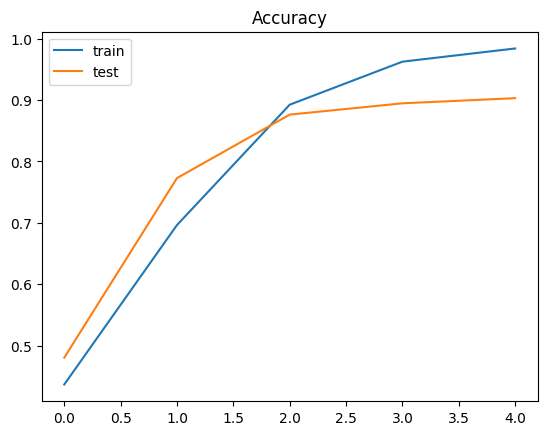

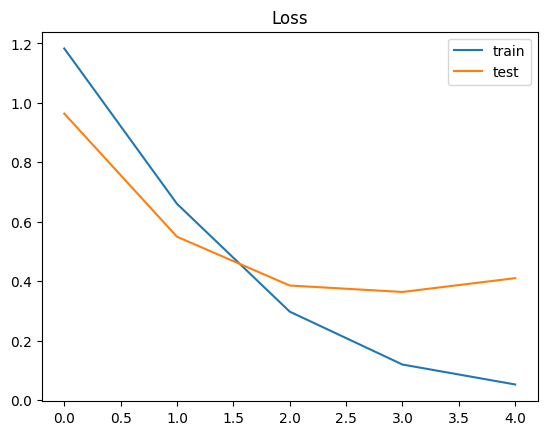

In [ ]:
# Plotting accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(trainhistory.history['accuracy'], label='train')
plt.plot(trainhistory.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(trainhistory.history['loss'], label='train')
plt.plot(trainhistory.history['val_loss'], label='test')
plt.legend()
plt.show();

###Model Evaluation

In [ ]:
results = model.evaluate(X_val, label_val, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.41053
Test Accuracy: 90.30%
